# Lab 1: Hands-on Time-series Anomaly Detection (TAD) for smart manufactoring

Pandas was updated on 03/04/2023 to version 2.0, which is not compatibile with tsfel. Dowgrade to 1.5.3

In [1]:
!pip install pandas==1.5.3
!pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#extract data
!unzip /content/drive/MyDrive/mlinapp/lab1/kukav1.zip -d /content/drive/MyDrive/mlinapp/lab1

Archive:  /content/drive/MyDrive/mlinapp/lab1/kukav1.zip
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec4_20220811_rbtc_0.01s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec3_20220811_rbtc_0.1s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec3_20220811_rbtc_0.01s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec4_20220811_rbtc_1.0s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec0_20220811_rbtc_0.005s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec4_20220811_rbtc_0.1s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec0_20220811_rbtc_0.1s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec0_20220811_rbtc_1.0s.csv  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec3_20220811_rbtc_1.0s.metadata  
  inflating: /content/drive/MyDrive/mlinapp/lab1/normal/rec3_20220811_rbtc_0.005s.metadata  
  inflating: /content/drive/MyDr

## Import and settings

In [4]:
import os
import time
import tsfel
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold

#switched dir
#ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/TeachingAndThesis/MLinAPP/2023/data/Kuka_v1/normal"
ROOTDIR_DATASET_NORMAL = "/content/drive/MyDrive/mlinapp/lab1/normal"

# Assignment #0: Write a function to create and plot a confusion matrix.
See [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) in sklearn.

In [29]:
def seaborn_cm(cm, ax, tick_labels, fontsize=14, title=None, sum_actual="over_columns",
               xrotation=0, yrotation=0):
    """
    Function to plot a confusion matrix
    """
    from matplotlib import cm as plt_cmap
    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    if sum_actual == "over_columns":
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    elif sum_actual == "over_rows":
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
    else:
        print("sum_actual must be over_columns or over_rows")
        exit()
    cm = np.nan_to_num(cm)
    mean_acc = np.mean(np.diag(cm)[cm.sum(axis=1) != 0])
    std_acc = np.std(np.diag(cm))
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=yrotation)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=xrotation)
    if title:
        title = f"{title}\nMean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    else:
        title = f"Mean accuracy {mean_acc * 100:.1f} +- {std_acc * 100:.1f}"
    ax.set_title(title)
    if sum_actual == "over_columns":
        ax.set_ylabel("Actual")
        ax.set_xlabel("Predicted")
    else:
        ax.set_ylabel("Predicted")
        ax.set_xlabel("Actual")
    ax.axis("off")

# Introduction

You are going to use the dataset provided in `data/Kuka_v1` folder, gathering actions performed by a [Kuka](https://www.kuka.com/it-it/prodotti-servizi/sistemi-robot/robot-industriali) industrial robot.
In this first part of this assignment, cosider only the time-series in the `normal` sub-folder.

In 4 different recording sessions, the robot executes a number of different operations, while being monitored by several sensors. The sensed signals are collected, with different sampling frequencies (1, 10, 100, 200 Hz), in the corresponding files saved using the following notation:

`rec{recording-session-id}_{recording-session-date}_rbtc_{frequency}s.csv `

For each of such file, a corresponding _metadata_ provides information concerning the action the robot is performing at the given timestamp.

`rec{recording-session-id}_{recording-session-date}_rbtc_{frequency}s.metadata `

Below an example of a `.csv` file and the corresponding `.metadata`

Example of .csv file

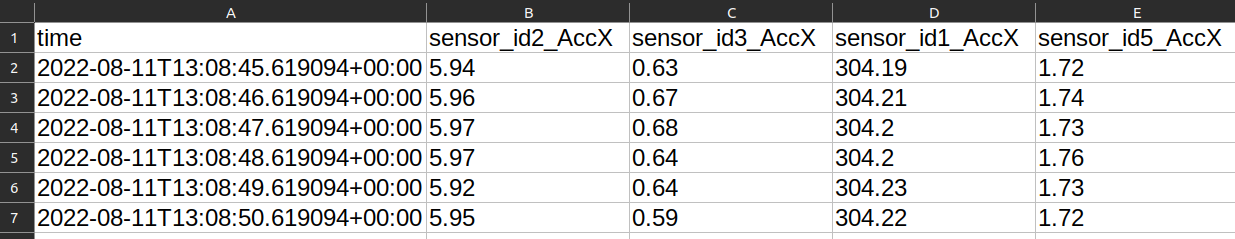

The `time` column reports the timestamps in which the sensors reading are collected (thus, the other columns are the various employed sensors).



Example of .metadata file

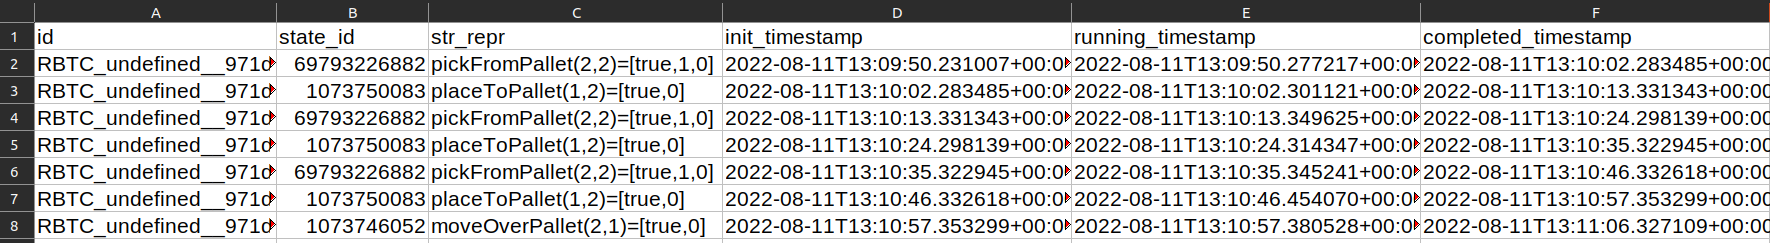

In this file, consider only the `str_repr` column, which indicates the action performed by the robot, and `init_timestamp` and `completed_timestamp` columns, giving information of the duration of such action.

---
**Objective: develop a model able to classify the robot's action given the sensors readings.**

Steps:

1.   Data loading
2.   Signal windowing
3.   Features extraction
4.   Features selection
5.   Classification


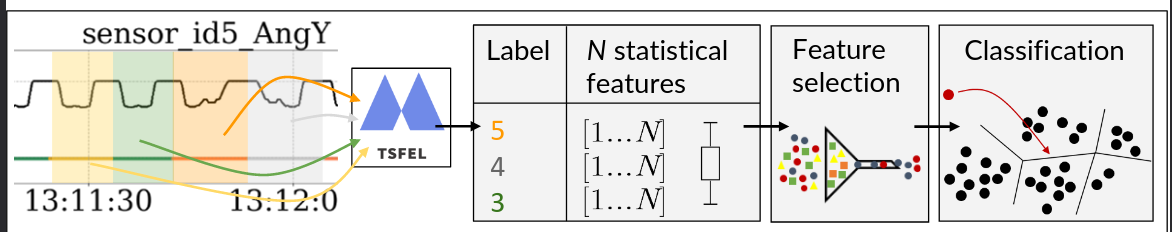

---

# Assignment #1: Data loading

This function loads sensor readings and the correspondig metadata. 
The output is a dataframe grouped by action.

In [5]:
def get_df_action(filepaths_csv, filepaths_meta, action2int=None, delimiter=";"):
    # Load dataframes
    print("Loading data.")
    # Make dataframes
    # Some classes show the output boolean parameter as True rather than true. Fix here
    dfs_meta = list()
    for filepath in filepaths_meta:
        df_m = pd.read_csv(filepath, sep=delimiter)
        df_m.str_repr = df_m.str_repr.str.replace('True', 'true')
        df_m['filepath'] = filepath
        dfs_meta.append(df_m)

    df_meta = pd.concat(dfs_meta)
    df_meta.index = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['completed_timestamp'] = pd.to_datetime(df_meta.completed_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
    df_meta['init_timestamp'] = pd.to_datetime(df_meta.init_timestamp.astype('datetime64[ms]'),
                                               format="%Y-%m-%dT%H:%M:%S.%f")

    # Eventually reduce number of classes
    # df_meta['str_repr'] = df_meta.str_repr.str.split('=', expand = True,n=1)[0]
    # df_meta['str_repr'] = df_meta.str_repr.str.split('(', expand=True, n=1)[0]

    actions = df_meta.str_repr.unique()
    dfs = [pd.read_csv(filepath_csv, sep=";") for filepath_csv in filepaths_csv]
    df = pd.concat(dfs)

    # Sort columns by name !!!
    df = df.sort_index(axis=1)

    # Set timestamp as index
    df.index = pd.to_datetime(df.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    # Drop useless columns
    columns_to_drop = [column for column in df.columns if "Abb" in column or "Temperature" in column]
    df.drop(["machine_nameKuka Robot_export_active_energy",
             "machine_nameKuka Robot_import_reactive_energy"] + columns_to_drop, axis=1, inplace=True)
    signals = df.columns

    df_action = list()
    for action in actions:
        for index, row in df_meta[df_meta.str_repr == action].iterrows():
            start = row['init_timestamp']
            end = row['completed_timestamp']
            df_tmp = df.loc[start: end].copy()
            df_tmp['action'] = action
            # Duration as string (so is not considered a feature)
            df_tmp['duration'] = str((row['completed_timestamp'] - row['init_timestamp']).total_seconds())
            df_action.append(df_tmp)
    df_action = pd.concat(df_action, ignore_index=True)
    df_action.index = pd.to_datetime(df_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    df_action = df_action[~df_action.index.duplicated(keep='first')]

    # Drop NaN
    df = df.dropna(axis=0)
    df_action = df_action.dropna(axis=0)

    if action2int is None:
        action2int = dict()
        j = 1
        for label in df_action.action.unique():
            action2int[label] = j
            j += 1

    df_merged = df.merge(df_action[['action']], left_index=True, right_index=True, how="left")
    # print(f"df_merged len: {len(df_merged)}")
    # Where df_merged in NaN Kuka is in idle state
    df_idle = df_merged[df_merged['action'].isna()].copy()
    df_idle['action'] = 'idle'
    df_idle['duration'] = df_action.duration.values.astype(float).mean().astype(str)
    df_action = pd.concat([df_action, df_idle])

    # ile label must be 0 for debug mode
    action2int['idle'] = 0
    print(f"Found {len(set(df_action['action']))} different actions.")
    print("Loading data done.\n")

    return df_action, df, df_meta, action2int

Load all data (and metadata) for frequency = 10 Hz

In [6]:
!ls {ROOTDIR_DATASET_NORMAL}

dataset.csv			      rec3_20220811_rbtc_0.005s.csv
rec0_20220811_rbtc_0.005s.csv	      rec3_20220811_rbtc_0.005s.metadata
rec0_20220811_rbtc_0.005s.metadata    rec3_20220811_rbtc_0.01s.csv
rec0_20220811_rbtc_0.01s.csv	      rec3_20220811_rbtc_0.01s.metadata
rec0_20220811_rbtc_0.01s.metadata     rec3_20220811_rbtc_0.1s.csv
rec0_20220811_rbtc_0.1s.csv	      rec3_20220811_rbtc_0.1s.metadata
rec0_20220811_rbtc_0.1s.metadata      rec3_20220811_rbtc_1.0s.csv
rec0_20220811_rbtc_1.0s.csv	      rec3_20220811_rbtc_1.0s.metadata
rec0_20220811_rbtc_1.0s_metadata.csv  rec4_20220811_rbtc_0.005s.csv
rec2_20220811_rbtc_0.005s.csv	      rec4_20220811_rbtc_0.005s.metadata
rec2_20220811_rbtc_0.005s.metadata    rec4_20220811_rbtc_0.01s.csv
rec2_20220811_rbtc_0.01s.csv	      rec4_20220811_rbtc_0.01s.metadata
rec2_20220811_rbtc_0.01s.metadata     rec4_20220811_rbtc_0.1s.csv
rec2_20220811_rbtc_0.1s.csv	      rec4_20220811_rbtc_0.1s.metadata
rec2_20220811_rbtc_0.1s.metadata      rec4_20220811_rbtc_1.0s.csv
rec

In [7]:
#only 10hz frequent
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.csv")for r in [0,2,3,4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_0.1s.metadata")for r in [0,2,3,4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.



In [8]:
df_action.head(2)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ,time,action,duration
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:09:50.319,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.87,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.319094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052
2022-08-11 13:09:50.419,165.617218,0.976074,1383.394043,49.951218,1618.833008,319.896576,126.683266,0.764916,-106.669258,228.842468,...,309.88,248.15,350.14,328.11,0.0,0.0,0.0,2022-08-11T13:09:50.419094+00:00,"pickFromPallet(2,2)=[true,1,0]",12.052


## Some plots

Plot some sensor signals plus an horizontal line indicating the robot's action for the given timestamp, leveraging:

1.   [Plotly Express](https://plotly.com/python/plotly-express/)
2.   [Plotly Graph Object](https://plotly.com/python/graph-objects/)

In [9]:
fig = go.Figure()
signals = [
    "sensor_id1_AngY",
    "sensor_id2_AngX",
    "sensor_id5_AngY",
    "sensor_id4_AccZ",
    "sensor_id4_AngX",
    "machine_nameKuka Robot_power"]

start = df.index[9000]
df_reduced = df.loc[start:]
duration = 120  # seconds
time_delta = df_reduced.index - start 
df_interval = df_reduced[time_delta.total_seconds() <= duration]
j = 0

# Leveraging plotly express
n_colors = len(signals)
colors = px.colors.sample_colorscale("greys", [n/(n_colors -1) for n in range(n_colors)])  # From continuous colormap
colors = px.colors.qualitative.Set2  # From discrete colormap, see https://plotly.com/python/discrete-color/
df_signals = df_interval[signals].select_dtypes(['number'])
df_signals = df_signals / df_signals.max()
fig = px.line(df_signals, x=df_signals.index, y=df_signals.columns, color_discrete_sequence=colors)

# Leveraging plotly graph object
colors_action = px.colors.qualitative.Antique
j = 0
for action in df_action.loc[df_interval.index].action.unique():
    df_action_interval = df_action.loc[df_interval.index]
    df_action_single_action = df_action_interval[df_action_interval['action'] == action]
    fig.add_trace(go.Scatter(
        x=df_action_single_action.index,
        y=[-0.3] * len(df_action_single_action.index),
        line_shape="hv",
        line=dict(color=colors_action[j], width=2.5),
        name=action))
    j += 1

Setting the Font, Title, Legend Entries, and Axis Titles (source: https://plotly.com/python/figure-labels/)


In [10]:
fig.update_layout(
    title="Some signals",
    xaxis_title="Time",
    yaxis_title="",
    legend_title="Legend",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="Black"
    )
)
fig.show()

## Assignment #1.1: With matplolib we can plot the columns of the selected signals directly from the dataframe.

Leverage and eventually personalize the personal file plot style *mystyle.mplstyle*

See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

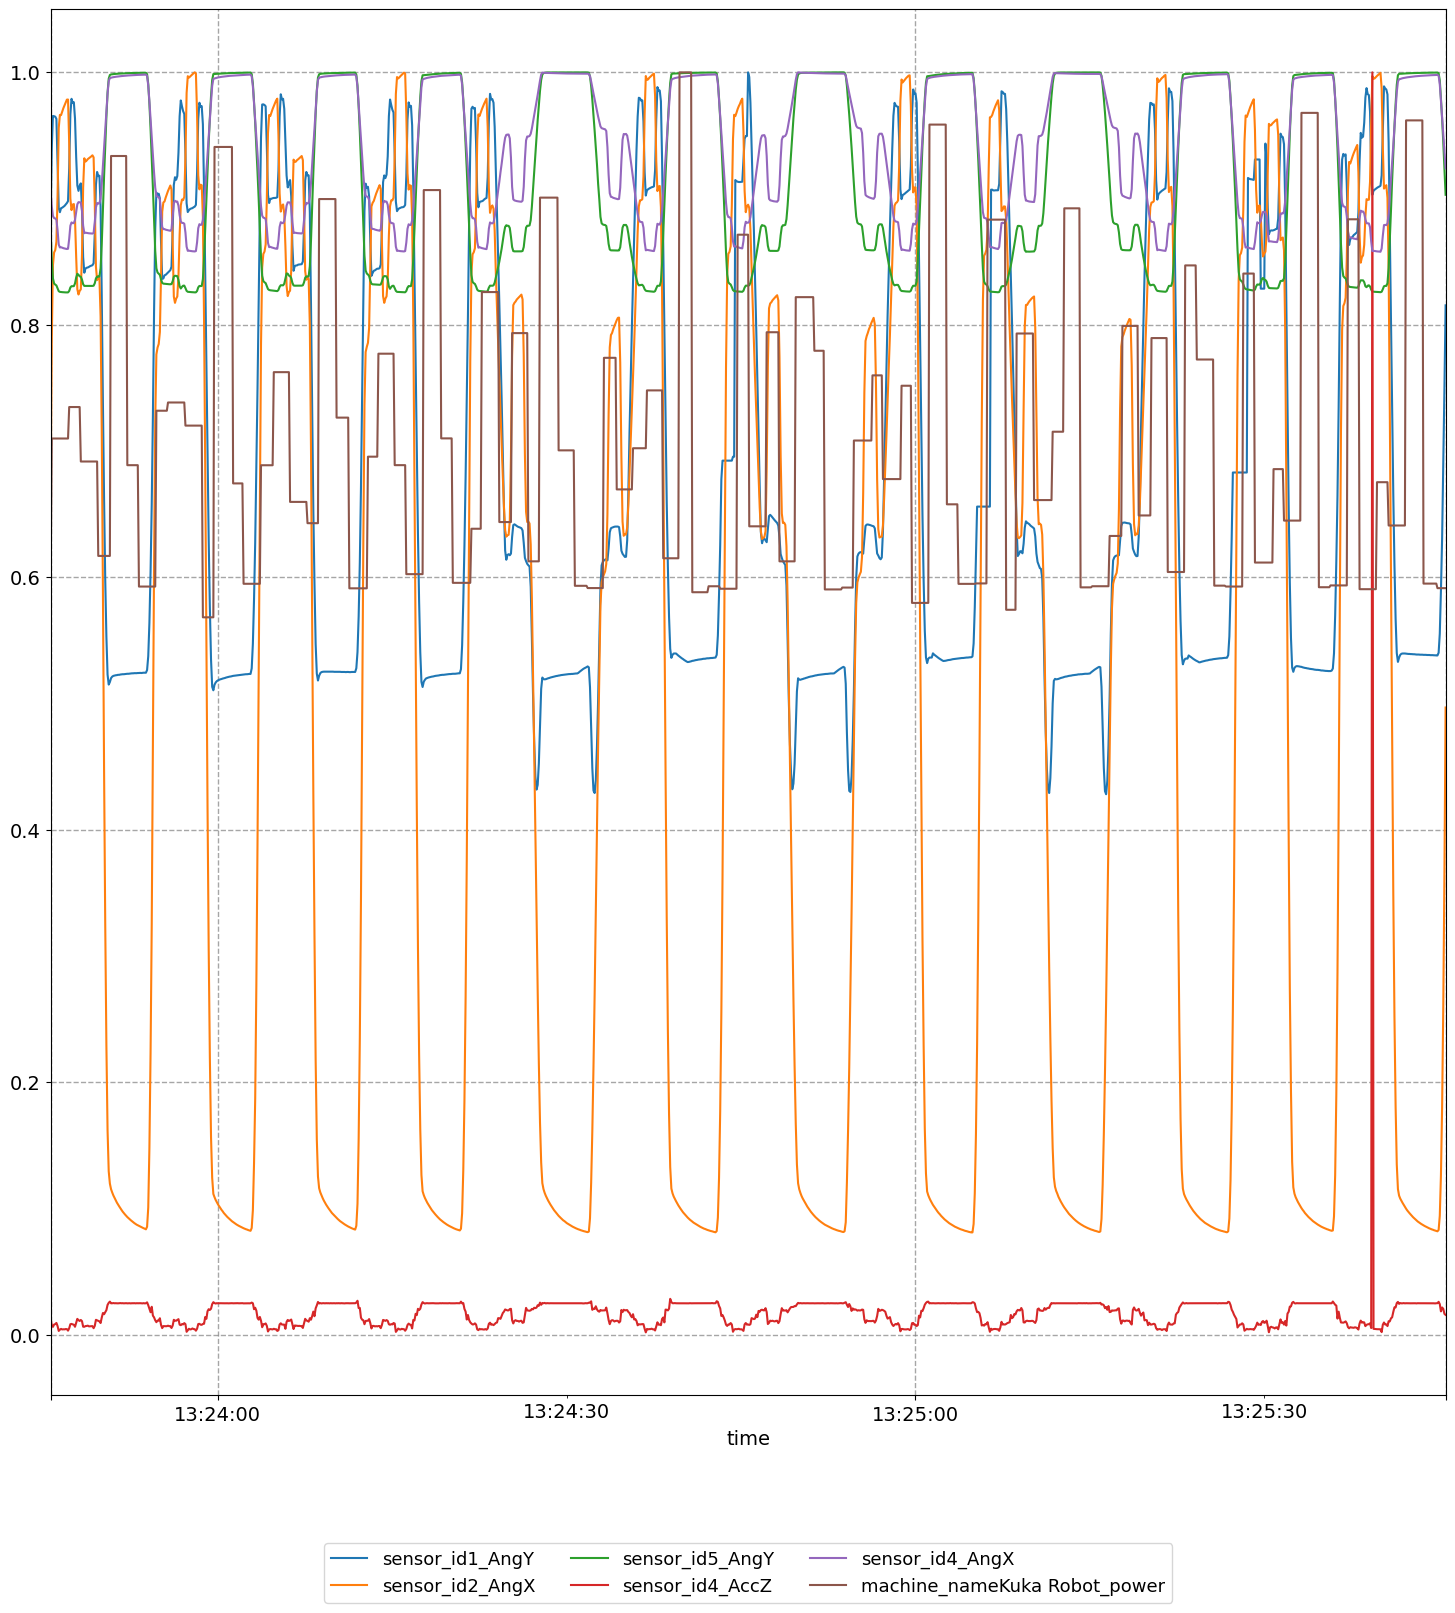

In [21]:
# Set a personal plot style
#  switching dir
# FILEPATH_PLT_STYLE = "/content/drive/MyDrive/TeachingAndThesis/MLinAPP/2023/basics/mystyle.mplstyle"
FILEPATH_PLT_STYLE = "/content/drive/MyDrive/mlinapp/lab0/basics/mystyle.mplstyle"
plt.style.use(FILEPATH_PLT_STYLE)
# ----
fig,ax = plt.subplots(1,1,figsize=(18,18))
df_signals.plot(ax=ax)
# ---
plt.legend(loc="upper center", bbox_to_anchor=(0.5,-0.1),ncol=3)

# Features extraction

We will leverage [Time Series Feature Extraction Library (TSFEL)](https://tsfel.readthedocs.io/en/latest/), to extract features from time series data. 

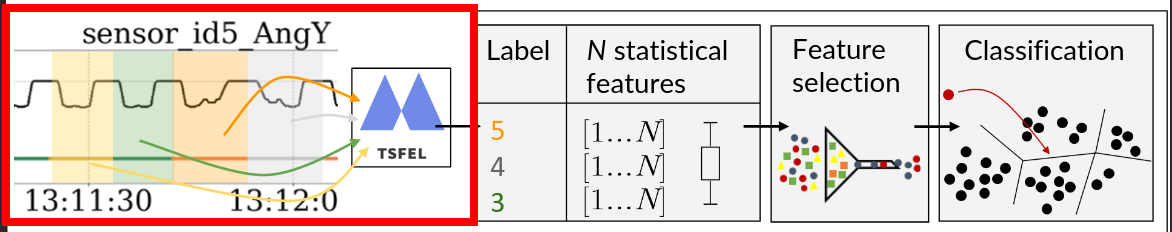

In [22]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def get_features_ts(domain, df_action, df_meta, frequency, action2int):
    duration_dict = {1: 10, 10: 1, 100: 0.1, 200: 0.05}
    duration_min = duration_dict[int(frequency)]
    cfg = tsfel.get_features_by_domain(domain)
    dataframe_features = list()
    print("Computing features.")
    # Idle does not have associated timestamps. Window is set to 10 seconds
    df_by_action = df_action[df_action["action"] == "idle"].copy()
    X = tsfel.time_series_features_extractor(cfg,
                                             df_by_action.select_dtypes(['number']),
                                             fs=frequency,
                                             header_names=df_by_action.select_dtypes(['number']).columns + '-',
                                             window_size=int(frequency * 10),
                                             verbose=False)
    time = pd.to_datetime(df_by_action.time.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
    X['start'] = [t[0] for t in
                  tsfel.utils.signal_processing.signal_window_splitter(time, window_size=int(frequency * 10))]
    X['duration'] = 10
    X['end'] = X['start'] + pd.to_timedelta(X['duration'], 's')
    X['label'] = action2int["idle"]
    X.drop('duration', inplace=True, axis=1)
    dataframe_features.append(X)
    actions = list(df_action.action.unique())
    actions.remove("idle")
    for action in actions:
        df_by_action = df_action[df_action["action"] == action].copy()
        df_meta_by_action = df_meta[df_meta['str_repr'] == action].copy()
        df_meta_by_action['start'] = pd.to_datetime(df_meta_by_action.init_timestamp.astype('datetime64[ms]'),
                                                    format="%Y-%m-%dT%H:%M:%S.%f")
        df_meta_by_action['end'] = pd.to_datetime(
            df_meta_by_action.completed_timestamp.astype('datetime64[ms]'), format="%Y-%m-%dT%H:%M:%S.%f")
        for _, row in df_meta_by_action.iterrows():
            df_by_action_by_event = df_by_action.loc[row["start"]: row["end"]]
            if len(df_by_action_by_event) < duration_min * frequency:
                print(f"Skipped feature extraction for {action} {row['start']} : {row['end']}.")
                continue

            X = tsfel.calc_window_features(cfg,
                                           df_by_action_by_event.select_dtypes(['number']),
                                           header_names=df_by_action_by_event.select_dtypes(['number']).columns + '-',
                                           fs=frequency,
                                           verbose=False)
            # print(X.shape)
            X['label'] = action2int[action]
            X['start'] = row['start']
            X['end'] = row['end']
            dataframe_features.append(X)

    dataframe_features = pd.concat(dataframe_features)
    print("Computing features done.")
    return dataframe_features

In [23]:
start_time = time.time()
df_features = get_features_ts("statistical", df_action, df_meta, 10, action2int)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
--- 362.07854080200195 seconds ---


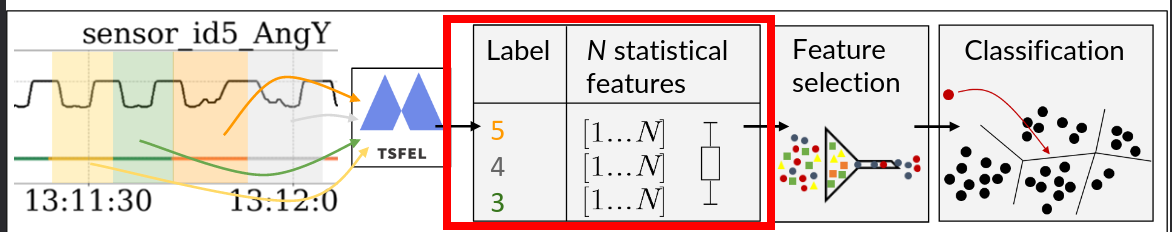

# Assignment #2: Prepare data for train and test

[Split arrays or matrices into random train and test subsets](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Note that:

*   the last three columns are the start, the end and the label corresponding to the action the robot is performing. Label is our gound truth, start and end can be dropped for the moment.
*   drop those columns showing NaN values.




In [24]:
df_features
#plot new features

,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1,machine_nameKuka Robot_apparent_power-_ECDF Percentile_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile_1,machine_nameKuka Robot_apparent_power-_ECDF_0,machine_nameKuka Robot_apparent_power-_ECDF_1,machine_nameKuka Robot_apparent_power-_ECDF_2,machine_nameKuka Robot_apparent_power-_ECDF_3,machine_nameKuka Robot_apparent_power-_ECDF_4,machine_nameKuka Robot_apparent_power-_ECDF_5,...,sensor_id5_GyroZ-_Median,sensor_id5_GyroZ-_Median absolute deviation,sensor_id5_GyroZ-_Min,sensor_id5_GyroZ-_Root mean square,sensor_id5_GyroZ-_Skewness,sensor_id5_GyroZ-_Standard deviation,sensor_id5_GyroZ-_Variance,start,end,label
0,20.0,80.0,165.678116,166.391693,0.01,0.02,0.03,0.04,0.05,0.06,...,0.000,0.000,0.0,0.000000,NaN,0.000000,0.000000e+00,2022-08-11 13:08:45.619,2022-08-11 13:08:55.619,0
1,20.0,80.0,165.733948,166.309937,0.01,0.02,0.03,0.04,0.05,0.06,...,0.000,0.000,0.0,0.000000,NaN,0.000000,0.000000e+00,2022-08-11 13:08:55.619,2022-08-11 13:09:05.619,0
2,20.0,80.0,165.572784,165.925323,0.01,0.02,0.03,0.04,0.05,0.06,...,0.000,0.000,0.0,0.000000,NaN,0.000000,0.000000e+00,2022-08-11 13:09:05.619,2022-08-11 13:09:15.619,0
3,20.0,80.0,165.572784,166.084869,0.01,0.02,0.03,0.04,0.05,0.06,...,0.000,0.000,0.0,0.000000,NaN,0.000000,0.000000e+00,2022-08-11 13:09:15.619,2022-08-11 13:09:25.619,0
4,20.0,80.0,165.209900,165.876617,0.01,0.02,0.03,0.04,0.05,0.06,...,0.000,0.000,0.0,0.000000,NaN,0.000000,0.000000e+00,2022-08-11 13:09:25.619,2022-08-11 13:09:35.619,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,20.0,80.0,192.217682,228.093018,0.01,0.02,0.03,0.04,0.05,0.06,...,66.495,66.495,0.0,2703.836308,0.160412,1980.703221,3.923185e+06,2022-08-11 15:30:57.369,2022-08-11 15:31:07.373,30
0,20.0,80.0,191.540497,244.435516,0.01,0.02,0.03,0.04,0.05,0.06,...,2011.750,1988.130,0.0,2819.663293,-0.000097,1986.966107,3.948034e+06,2022-08-11 15:31:17.342,2022-08-11 15:31:27.352,30
0,20.0,80.0,192.126190,246.307220,0.01,0.02,0.03,0.04,0.05,0.06,...,53.165,53.165,0.0,2643.963814,0.241633,1972.557476,3.890983e+06,2022-08-11 16:10:31.682,2022-08-11 16:10:41.684,30
0,20.0,80.0,191.903839,221.400757,0.01,0.02,0.03,0.04,0.05,0.06,...,34.245,34.245,0.0,2551.538346,0.365859,1954.279344,3.819208e+06,2022-08-11 16:10:51.691,2022-08-11 16:11:01.717,30


In [25]:
df_features.isnull().values.any()

True

In [26]:
df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()),axis=1)

In [27]:
df_train, df_test =train_test_split(df_features_nonan)

In [28]:
X_train = df_train.drop(["label","start","end"],axis=1)
y_train = df_train["label"]
X_test = df_test.drop(["label","start","end"],axis=1)
y_test = df_test["label"]

# Assignment #3: Train a SVM model

Instead of using a grid of parameter settings for parameter optimization, leverage [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn-model-selection-randomizedsearchcv) to implement a randomized search over parameters where each setting is sampled from a distribution over possible parameter values. This is much more computationally convenient than an exhaustive search.

Define the grid as a python dictionary

In [30]:
random_grid_svm = {
    "kernel": ["rbf","poly","sigmoid"],
    "gamma": ["scale","auto",0.0001,0.001,0.01,0.1],
    "degree": [2,3,4,5],
    "class_weight": [None,"balanced"],
    "C": [0.01,0.1,0.5,1,2,5,10,20,50,100,200,500,1000]
}

Instantiate the search

In [31]:
search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=random_grid_svm,
    scoring="balanced_accuracy",
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

Fit the search (on training, obv.) and take the best classifier

In [32]:
search.fit(X_train, y_train)
classifier=search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Evaluate the model on the training set via a confusion matrix

In [33]:
def evaluate (calssifier,dataset,ground_trouth,action2int):
  predictions=classifier.predict(dataset)
  cm=confusion_matrix(ground_trouth,predictions,labels=list(action2int.values()))
  fig,ax=plt.subplots(1,1,figsize=(13,13))
  int2action={v:k for k, v in action2int.items()}
  seaborn_cm(cm,ax,[int2action[l]for l in action2int.values()],fontsize=9,xrotation=99)

Evaluate on the test set

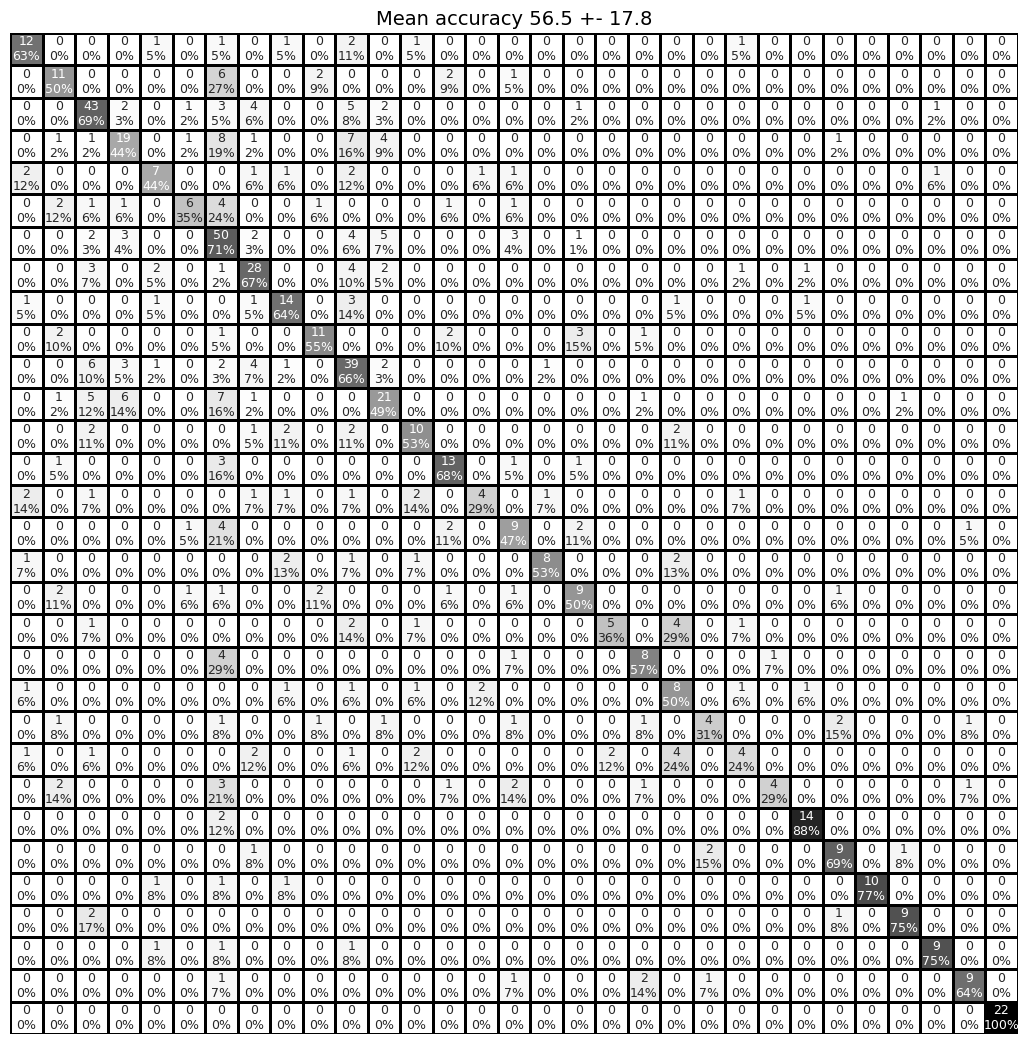

In [34]:
evaluate(classifier,X_train,y_train,action2int)

# Assignment #4: Standardization effect

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In practice we often ignore the shape of the distribution and just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation.
Implement a [standar scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler) via sklearn

In [35]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_norm = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)
search.fit(X_train_norm, y_train)
classifier = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Evaluate on both train and test

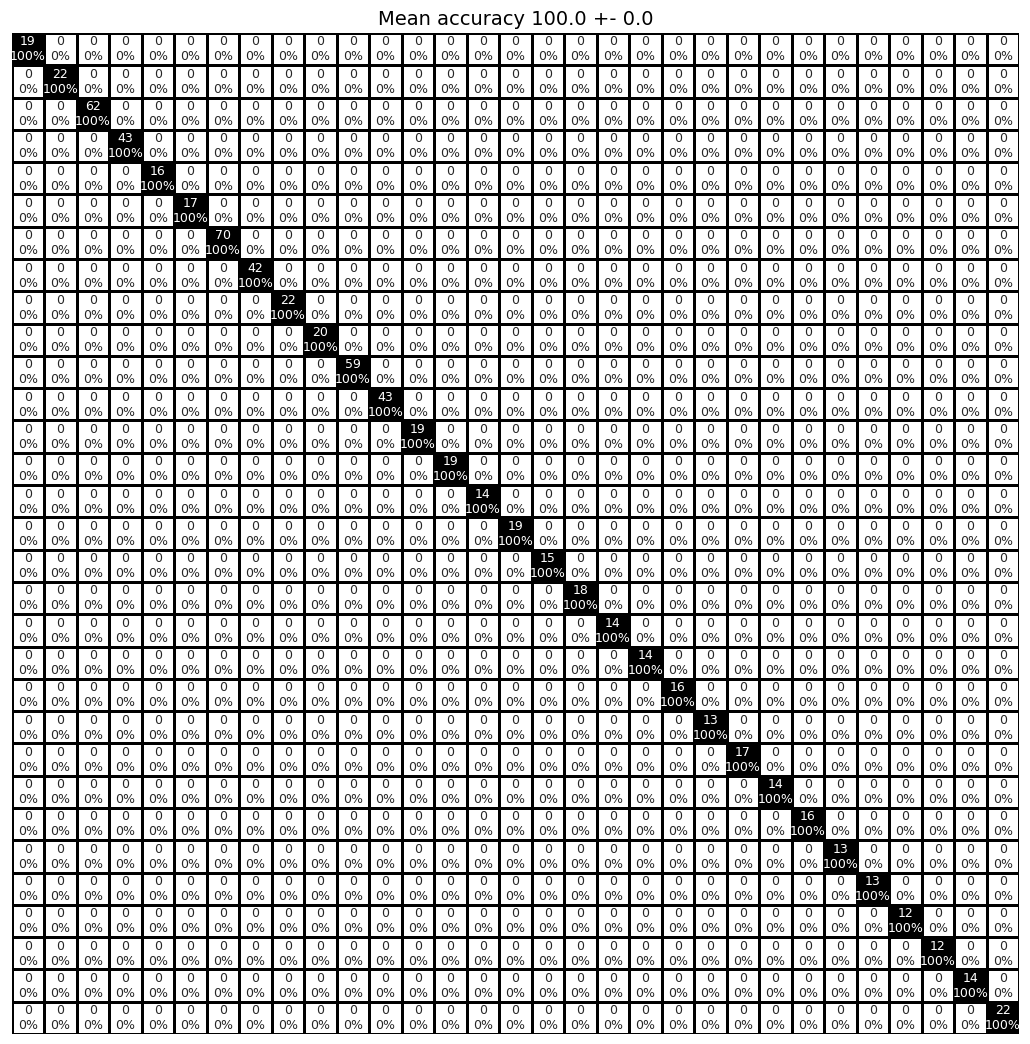

In [36]:
evaluate(classifier,X_train_norm,y_train,action2int)

## Let's have a look at the distribution of the variance among features. Exploit 

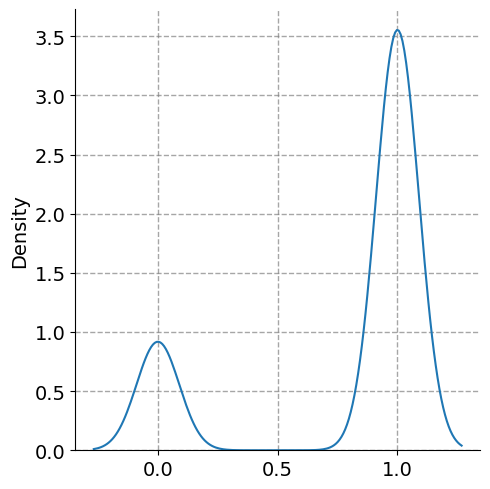

In [37]:
sns.displot(X_train_norm.std(), kind="kde")

sns.displot with kind="hist" (the default)  produces 28026496530586984 bins, which hits resource limits when matplotlib tries to draw that many rectangles.
See https://github.com/mwaskom/seaborn/issues/2325#issuecomment-712249812

We can observe a two-modal distribution: several features show a 0-variance. We can remove them leveraging [sklearn.feature_selection.VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) 

In [38]:
selector_variance = VarianceThreshold()
selector_variance.fit(X_train_norm)
X_train_variance = pd.DataFrame(selector_variance.transform(X_train_norm),
                                columns=X_train_norm.columns.values[selector_variance.get_support()])

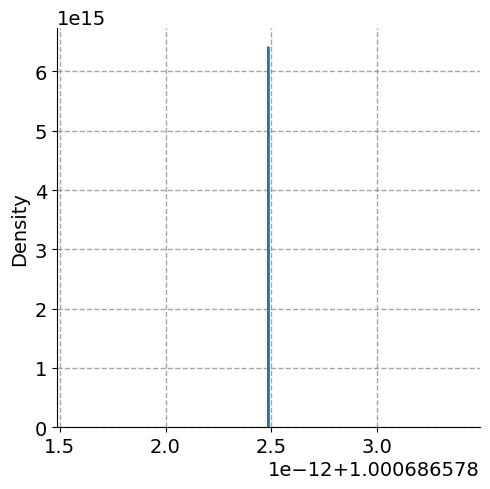

In [39]:
sns.displot(X_train_variance.std(), kind="kde")

Much better, nonetheless, we can still observe a strong correlation among features

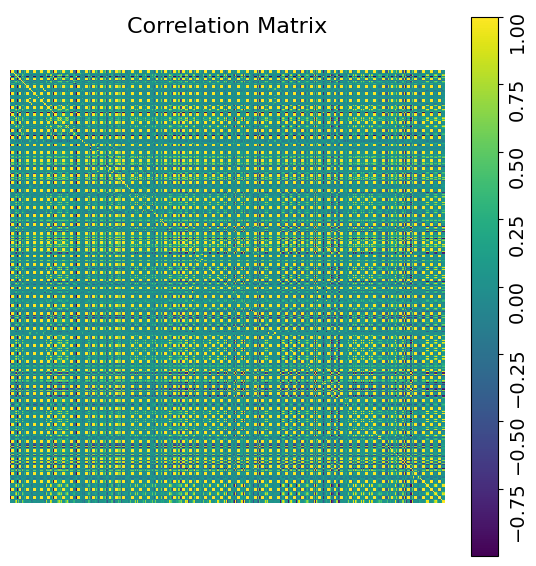

In [40]:
def plot_correlation_matrix(df, ax, show_ticks=False):
    mat = ax.matshow(df.corr())
    if show_ticks:
        ax.set_xticks(range(df.select_dtypes(['number']).shape[1]), 
                df.select_dtypes(['number']).columns, 
                fontsize=8, rotation=270)
        ax.set_yticks(range(df.select_dtypes(['number']).shape[1]), 
                df.select_dtypes(['number']).columns, 
                fontsize=8, rotation=0)
    else:
        ax.axis("off")
    ax.grid(False)
    cb = fig.colorbar(mat, ax=ax)
    cb.ax.tick_params(labelsize=14, labelrotation=90)
    ax.set_title('Correlation Matrix', fontsize=16);

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plot_correlation_matrix(X_train_variance, ax)